In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import matplotlib.pyplot as plt
from hydra import initialize, compose
from pathlib import Path
from collections import defaultdict
import matplotlib.colors
import numpy as np

In [5]:
with initialize(version_base=None, config_path="../configs/filepaths", ):
    filepaths = compose(config_name="filepaths")

In [6]:
Rs = [0, 1, 2, 3, 4]
dts = [91, 13, '04', '02', '01']
mechinferred_template_sizes = defaultdict(list)
rcr_template_sizes = defaultdict(list)
bad_rules = {'rcr': set(), 'mechinferred': set()}
mechinferred_rules = []
rcr_rules = []

for dt in dts:
    df = pd.read_csv(
        Path(filepaths.processed_data) / f"mechinferred_dt_{dt}_rules.csv",
    )
    mechinferred_rules.append(df)
    for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        mechinferred_template_sizes[dt].append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )

for R in Rs:
    if R == 0:
        df = pd.read_csv(
            Path(filepaths.rules) / "rc_plus_0_rules.csv",
        )
    else:
        df = pd.read_csv(
            Path(filepaths.processed_data) / f"rc_plus_{R}_rules.csv",
        )
    rcr_rules.append(df)
    for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        rcr_template_sizes[R].append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )

mechinformed_template_sizes = []
df = pd.read_csv(
    Path(filepaths.processed_data) / "mechinformed_rules.csv",
)
for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        mechinformed_template_sizes.append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )


In [7]:
for df, cts in zip(mechinferred_rules, mechinferred_template_sizes.values()):
    df["n_atoms"] = cts
for df, cts in zip(rcr_rules, rcr_template_sizes.values()):
    df["n_atoms"] = cts

In [8]:
mechinferred_rules[4].sort_values(by="n_atoms", ascending=False)

,id,smarts,rc_plus_0_id,n_atoms
8178,8178,[*:1](~[*:2]~[O&D2&v2&H0&+0&!R:3]-[P&D4&v5&H0&...,228,187
8176,8176,[*:1](~[*:2]~[O&D2&v2&H0&+0&!R:3]-[P&D4&v5&H0&...,228,186
8177,8177,[*:1](~[*:2]~[O&D2&v2&H0&+0&!R:3]-[P&D4&v5&H0&...,517,180
8174,8174,[*:1](~[*:2]~[O&D2&v2&H0&+0&!R:3]-[P&D4&v5&H0&...,517,180
1185,1185,[C&D3&v4&H1&+0&R&z1:1](-[O&D1&v2&H1&+0&!R:2])-...,517,179
...,...,...,...,...
4277,4277,[C&D4&v4&H0&+0&!R&z1:1](-[O&D1&v2&H1&+0&!R:2])...,1009,3
2453,2453,[C&D1&v4&H1&+0&!R&z1:1]#[N&D1&v3&H0&+0&!R:2].[...,549,3
2459,2459,[C&D2&v4&H1&+0&R&z1:1]=[N&D2&v3&H0&+0&R:2].[O&...,499,3
1,1,[C&D2&v4&H0&+0&!R&z2:1]#[N&D1&v3&H0&+0&!R:2].[...,785,3


In [9]:
rcr_rules[4].sort_values(by="n_atoms", ascending=False)

,id,smarts,rc_plus_0_id,n_atoms
7773,7773,[N&D1&v3&H2&+0&!R:1]-[C&D3&v4&H0&+0&!R&z2:2](=...,337,51
7770,7770,[N&D1&v3&H2&+0&!R:1]-[C&D3&v4&H0&+0&!R&z2:2](=...,463,51
2463,2463,[C&D1&v4&H2&+0&!R&z0:1]=[C&D2&v4&H1&+0&!R&z0:2...,684,49
7771,7771,[N&D1&v3&H2&+0&!R:1]-[C&D3&v4&H0&+0&!R&z2:2](=...,463,48
7772,7772,[N&D1&v3&H2&+0&!R:1]-[C&D3&v4&H0&+0&!R&z2:2](=...,337,48
...,...,...,...,...
12347,12347,[O&D1&v2&H0&+0&!R:1]=[C&D3&v4&H0&+0&!R&z3:2](-...,821,4
2151,2151,[C&D1&v4&H1&+0&!R&z1:1]#[N&D1&v3&H0&+0&!R:2].[...,549,3
6290,6290,[C&D1&v4&H3&+0&!R&z0:1]-[C&D2&v4&H1&+0&!R&z1:2...,185,3
2105,2105,[C&D1&v4&H1&+0&!R&z0:1]#[C&D1&v4&H1&+0&!R&z0:2...,553,3


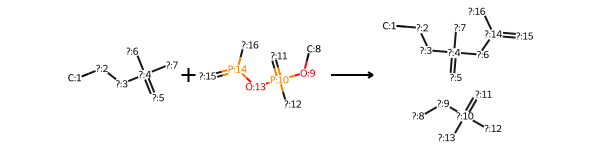

In [10]:
AllChem.ReactionFromSmarts(mechinferred_rules[2].loc[4439, "smarts"])

In [23]:
colors = {
    'rc_plus_0_rules': matplotlib.colors.to_rgba("black", alpha=0.3),
    'rc_plus_1_rules':matplotlib.colors.to_rgba("black", alpha=0.45),
    'rc_plus_2_rules': matplotlib.colors.to_rgba("black", alpha=0.6),
    'rc_plus_3_rules': matplotlib.colors.to_rgba("black", alpha=0.85),
    'rc_plus_4_rules': matplotlib.colors.to_rgba("black", alpha=1.0),
    'mechinferred_dt_91_rules': matplotlib.colors.to_rgba("purple", alpha=0.3),
    'mechinferred_dt_13_rules': matplotlib.colors.to_rgba("purple", alpha=0.45),
    'mechinferred_dt_04_rules': matplotlib.colors.to_rgba("purple", alpha=0.6),
    'mechinferred_dt_02_rules': matplotlib.colors.to_rgba("purple", alpha=0.85),
    'mechinferred_dt_01_rules': matplotlib.colors.to_rgba("purple", alpha=1.0),
    'mechinformed_rules': matplotlib.colors.to_rgba("green")
    
}

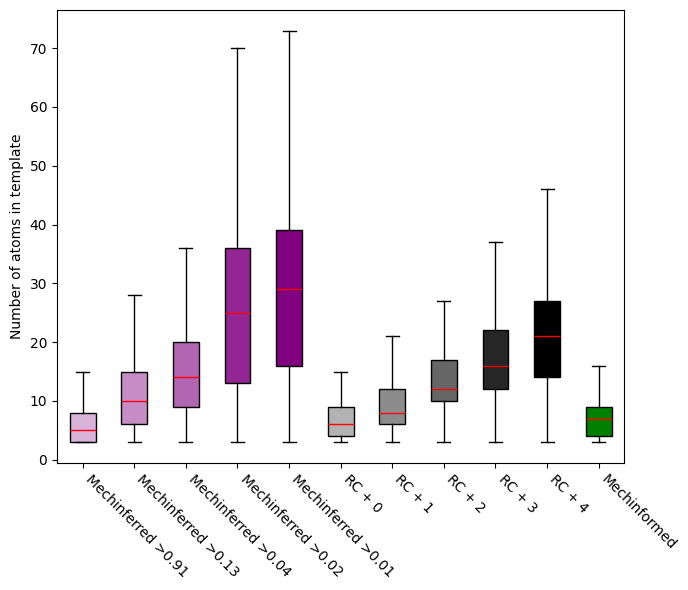

In [25]:
fig, ax = plt.subplots(figsize=(7, 6))
data = []
width = 0.5

for dt, cts in mechinferred_template_sizes.items():
    data.append(cts)
for R, cts in rcr_template_sizes.items():
    data.append(cts)

data.append(mechinformed_template_sizes)

positions = list(range(len(mechinferred_template_sizes) + len(rcr_template_sizes) + 1))

bw_plot = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, showfliers=False, medianprops={'color': 'red'})

for path, dt in zip(bw_plot['boxes'], mechinferred_template_sizes.keys()):
    color_key = f"mechinferred_dt_{dt}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

for path, R in zip(bw_plot['boxes'][len(mechinferred_template_sizes):], rcr_template_sizes.keys()):
    color_key = f"rc_plus_{R}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

bw_plot['boxes'][-1].set_facecolor(colors['mechinformed_rules'])

ax.set_xticks(positions)
xticklabels = [f"Mechinferred >{int(dt)/100:.2f}" for dt in dts] + [f"RC + {R}" for R in Rs] + ["Mechinformed"]
ax.set_xticklabels(xticklabels, rotation=-45, ha='left')
ax.set_ylabel("Number of atoms in template")
plt.tight_layout()
fig.savefig(Path(filepaths.figures) / "template_size_boxplot.svg", format='svg')
plt.show()